#### 加载模型验证预测效果

In [1]:
import torch

from torch.utils.data import DataLoader
from misc.data_loader import StockDataset, DataType

In [2]:
valid_glob_path = "data/process/5min/NVDA.valid.csv"
max_seq_len = 300
random_split_ratio = 0
use_time_feature = True
data_type = DataType.US_STOCK_5MIN.value

In [3]:
# init valid dataset
valid_dataset = StockDataset(
    files_list=[valid_glob_path],
    maxseq_len=max_seq_len,
    random_split_ratio=random_split_ratio,
    use_time_feature=use_time_feature,
    data_type=DataType(data_type),
    cache_size=1,
    random_mask_ratio=0,
)

In [79]:
# init valid dataset
import glob
valid_dataset_all = StockDataset(
    files_list= glob.glob("data/process/5min/*.valid.csv"),
    maxseq_len=max_seq_len,
    random_split_ratio=random_split_ratio,
    use_time_feature=use_time_feature,
    data_type=DataType(data_type),
    cache_size=10,
    random_mask_ratio=0,
)

In [4]:
batch_size = 1
price_channel_index = 0
device = 'cuda'
model_arch = "512|8|8"

In [5]:
from model.llm_mix_tst import LLMMixTST, ModelArgs

n_dim, n_layer, n_head = model_arch.split("|")
patch_len = 12
params = ModelArgs(
        dim=int(n_dim),
        n_layers=int(n_layer),
        n_heads=int(n_head),
        max_seq_len=max_seq_len,
        dropout=0.1,
        n_channel=len(StockDataset.ChannelNames),
        device=device,
        use_time_feature=True,
        time_feature_dim=5,
        stride=patch_len,
        patch_len=patch_len
)
print("use mix channel test...")
params.price_channel = price_channel_index

# 实例化模型
model = LLMMixTST(params)
model.load_state_dict(torch.load('data/models/model_weights.pth'))
model.to(device)
model.eval()

use mix channel test...


LLMMixTST(
  (revin_layer): RevIN()
  (patch_proj): Linear(in_features=12, out_features=512, bias=True)
  (time_proj): Linear(in_features=60, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=512, bias=False)
        (wv): Linear(in_features=512, out_features=512, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=512, out_features=1376, bias=False)
        (w2): Linear(in_features=1376, out_features=512, bias=False)
        (w3): Linear(in_features=512, out_features=1376, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (atte

In [ ]:
valid_loss = 0
batch_num = 0

valid_data_loader_all = DataLoader(valid_dataset_all, batch_size=50)
valid_data_loader_all.dataset.reset()

for batch_idx, data in enumerate(valid_data_loader_all):
    seq = data[0].to(device).float()
    seq_len = data[1].to(device).int()
    time_feat = None
    if len(data) > 2:
        time_feat = data[2].to(device).float()
        predict_out = model(seq, time_feat)
        val_loss, channel_loss = model.pretrain_loss(seq, seq_len, predict_out)
        valid_loss += val_loss.item()
        batch_num += 1
        # 计算平均验证损失
        valid_loss /= batch_num

In [6]:
class SampleResult(object):
    def __init__(self, seq: list, seq_len: int, pred: list, pred_idx: int, loss:float):
        self.seq: list = seq
        self.seq_len: int = seq_len
        self.pred: list = pred
        self.pred_idx = pred_idx
        self.loss = loss

In [7]:

valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size)
valid_data_loader.dataset.reset()

result = []

for batch_idx, data in enumerate(valid_data_loader):
    seq = data[0].to(device).float()
    seq_len = data[1].to(device).int()
    time_feat = None
    if len(data) > 2:
        time_feat = data[2].to(device).float()
        predict_out = model(seq, time_feat)
        val_loss, channel_loss = model.pretrain_loss(seq, seq_len, predict_out)
        # batch x patch x predict_num x patch_length
        input_seq = seq[:, :, price_channel_index]
        input_seq = input_seq.unfold(dimension=-1, size=patch_len, step=patch_len)
        for idx in range(seq.shape[0]):
            for idy in range(predict_out.shape[2]):
                l1 = input_seq[idx, (1+idy):, :]
                p1 = predict_out[idx, :-(1+idy), idy, :]
                result.append(SampleResult(torch.flatten(l1).tolist(), 
                                           seq_len[idx].item() - (1+idx) * patch_len, 
                                           torch.flatten(p1).tolist(), 
                                           idy, val_loss.item()))
    

[0.3771395683288574, 0.37612760066986084, 0.3757472634315491, 0.3794476091861725, 0.3745151162147522, 0.3779352307319641, 0.371317982673645, 0.37071579694747925, 0.37059515714645386, 0.37176281213760376, 0.3693440854549408, 0.3741030991077423, 0.3757105767726898, 0.37354207038879395, 0.3739868998527527, 0.3783717155456543, 0.37965837121009827, 0.3813820481300354, 0.3860948979854584, 0.3820492625236511, 0.380325585603714, 0.38544100522994995, 0.38933318853378296, 0.39489343762397766, 0.39513808488845825, 0.3922806680202484, 0.3917241096496582, 0.39111247658729553, 0.39205771684646606, 0.3893887996673584, 0.38986140489578247, 0.3869422972202301, 0.38271650671958923, 0.3792135417461395, 0.3803817331790924, 0.3829388916492462, 0.3875539004802704, 0.38427335023880005, 0.38933318853378296, 0.38766565918922424, 0.38427335023880005, 0.3812152147293091, 0.37949153780937195, 0.37946319580078125, 0.3788243234157562, 0.3778790831565857, 0.37986186146736145, 0.3766096830368042, 0.37337526679039, 0.

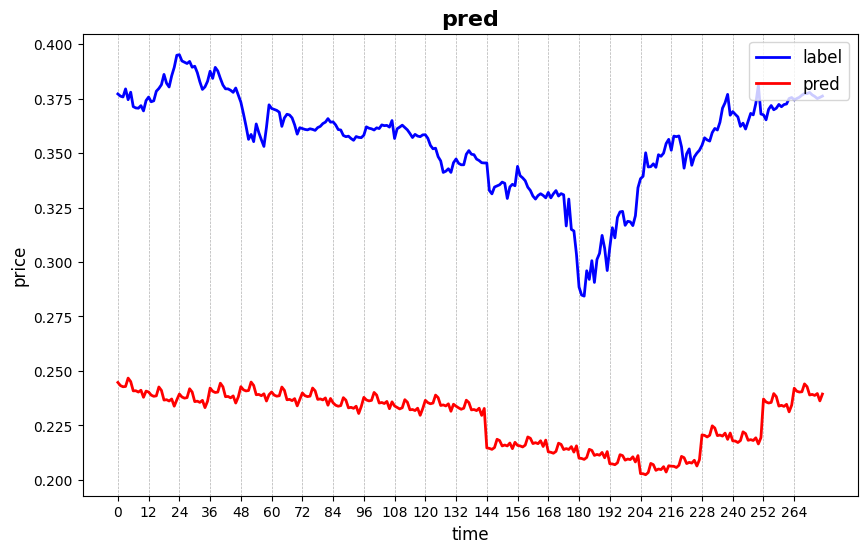

[0.5513032674789429, 0.552971363067627, 0.5640918612480164, 0.5596436858177185, 0.560755729675293, 0.5608113408088684, 0.560755729675293, 0.5623682141304016, 0.5620901584625244, 0.5613673329353333, 0.5599772930145264, 0.552971363067627, 0.5551398396492004, 0.5513032674789429, 0.5501912236213684, 0.5512476563453674, 0.5493571758270264, 0.5457430481910706, 0.5478559136390686, 0.5460766553878784, 0.5466326475143433, 0.549079179763794, 0.5542502403259277, 0.5552510619163513, 0.5618677735328674, 0.555918276309967, 0.5558293461799622, 0.5526933670043945, 0.5516924858093262, 0.5547506213188171, 0.55686354637146, 0.5525265336036682, 0.5470218658447266, 0.5471886992454529, 0.5496352314949036, 0.5485231876373291, 0.5502468347549438, 0.5482451319694519, 0.5480227470397949, 0.5435189604759216, 0.5465214848518372, 0.5528045296669006, 0.5461322665214539, 0.5583353638648987, 0.5525821447372437, 0.5602908730506897, 0.5756949782371521, 0.5679840445518494, 0.5605055093765259, 0.5362350344657898, 0.53173

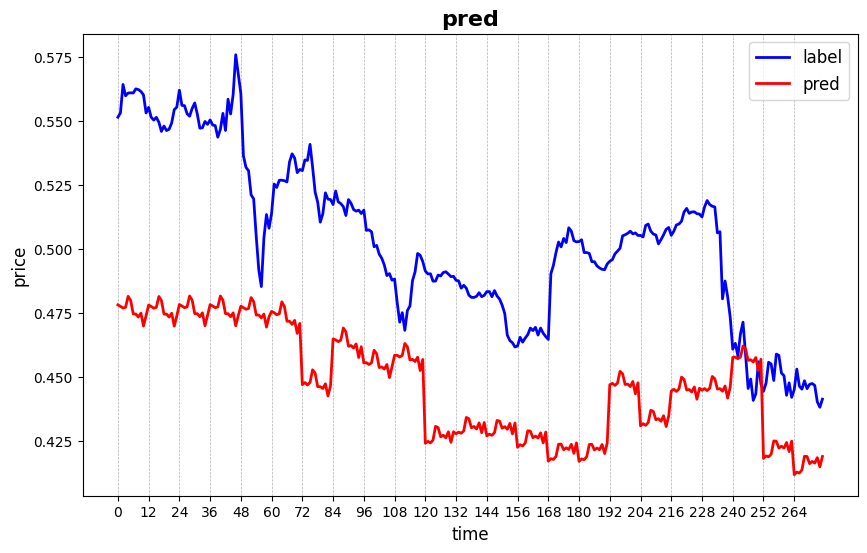

[1.147807002067566, 1.1492514610290527, 1.1490302085876465, 1.147528886795044, 1.142682671546936, 1.1486965417861938, 1.1440259218215942, 1.1352407932281494, 1.1568145751953125, 1.1496974229812622, 1.144701600074768, 1.1373836994171143, 1.1366864442825317, 1.134239912033081, 1.133294701576233, 1.1380208730697632, 1.1440259218215942, 1.1399669647216797, 1.1390217542648315, 1.1461610794067383, 1.1464169025421143, 1.1472508907318115, 1.1553232669830322, 1.1607067584991455, 1.1534783840179443, 1.142305612564087, 1.1486965417861938, 1.1510318517684937, 1.157676339149475, 1.1574262380599976, 1.1589274406433105, 1.1568701267242432, 1.1540066003799438, 1.1492526531219482, 1.150726079940796, 1.1537158489227295, 1.1579822301864624, 1.1410233974456787, 1.131320834159851, 1.1249265670776367, 1.1276010274887085, 1.1216354370117188, 1.1304311752319336, 1.1240646839141846, 1.1284295320510864, 1.1317055225372314, 1.1325724124908447, 1.1258995532989502, 1.1266224384307861, 1.1212846040725708, 1.1102195

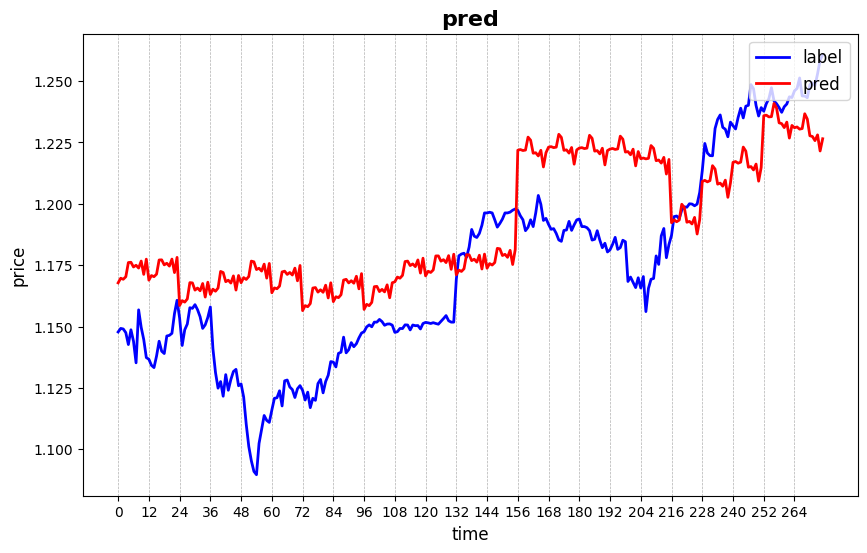

[1.8383899927139282, 1.8390578031539917, 1.8398913145065308, 1.836833119392395, 1.8393347263336182, 1.8406141996383667, 1.8394465446472168, 1.8399468660354614, 1.839668869972229, 1.8401693105697632, 1.8405029773712158, 1.84100341796875, 1.84684157371521, 1.8430606126785278, 1.843116283416748, 1.8451735973358154, 1.84684157371521, 1.8500665426254272, 1.8501222133636475, 1.852401852607727, 1.8520126342773438, 1.8522350788116455, 1.8534027338027954, 1.8540699481964111, 1.8536251783370972, 1.8551820516586304, 1.854625940322876, 1.84923255443573, 1.8482316732406616, 1.850733757019043, 1.850733757019043, 1.850733757019043, 1.852401852607727, 1.854625940322876, 1.8549039363861084, 1.854514718055725, 1.852401852607727, 1.850733757019043, 1.8497329950332642, 1.8496217727661133, 1.8477869033813477, 1.8458963632583618, 1.8497329950332642, 1.850288987159729, 1.850733757019043, 1.849677324295044, 1.8483428955078125, 1.8482873439788818, 1.8496217727661133, 1.8489545583724976, 1.8473976850509644, 1.8

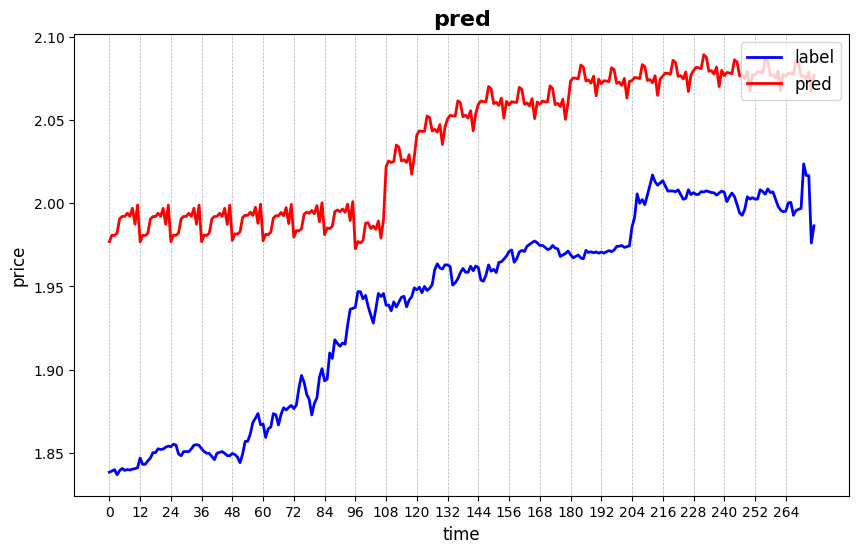

[0.40712597966194153, 0.3951708972454071, 0.39253032207489014, 0.3857746422290802, 0.3865530788898468, 0.3830779194831848, 0.3804006576538086, 0.39433741569519043, 0.39800718426704407, 0.4010097086429596, 0.403067022562027, 0.39400380849838257, 0.4052911102771759, 0.4099339246749878, 0.41179659962654114, 0.41479969024658203, 0.41949865221977234, 0.4214158356189728, 0.41852450370788574, 0.4214714467525482, 0.4198584258556366, 0.41352027654647827, 0.41118496656417847, 0.41040652990341187, 0.4099061191082001, 0.4185801148414612, 0.4245295822620392, 0.42430660128593445, 0.4313686788082123, 0.42747652530670166, 0.42630940675735474, 0.4271150827407837, 0.42008137702941895, 0.42186009883880615, 0.42600303888320923, 0.42769891023635864, 0.43031224608421326, 0.43131309747695923, 0.4184688925743103, 0.4188581109046936, 0.4170788526535034, 0.4153551757335663, 0.4084109663963318, 0.40912768244743347, 0.41958096623420715, 0.4246963858604431, 0.4309238791465759, 0.42408475279808044, 0.42197185754776

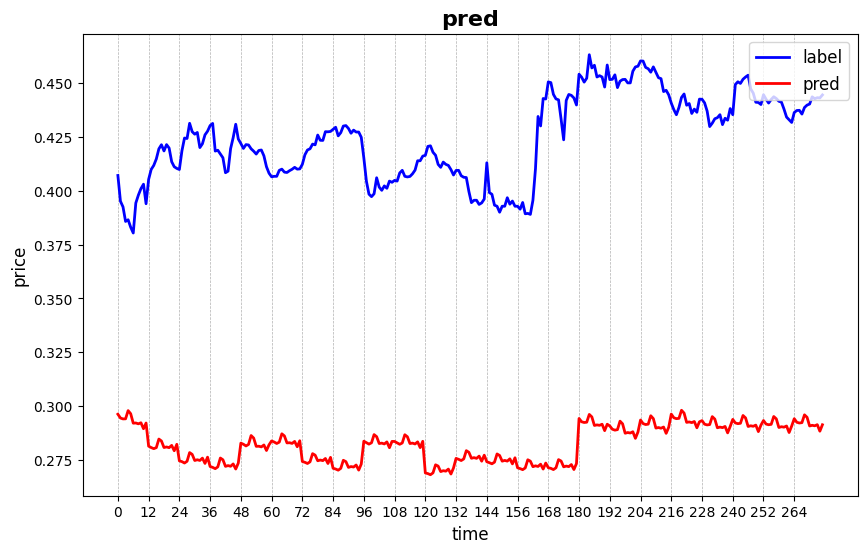

[0.44385144114494324, 0.4362061023712158, 0.4300898313522339, 0.43042343854904175, 0.436928927898407, 0.4390980005264282, 0.44026508927345276, 0.42950600385665894, 0.42358434200286865, 0.430979460477829, 0.4261976480484009, 0.419080525636673, 0.4239179491996765, 0.4338151812553406, 0.4323139190673828, 0.4321471154689789, 0.43120187520980835, 0.43275874853134155, 0.4333147704601288, 0.43353718519210815, 0.4239179491996765, 0.4356500804424286, 0.4349828362464905, 0.433870792388916, 0.4340932071208954, 0.4337039887905121, 0.43442681431770325, 0.4344273805618286, 0.4337039887905121, 0.4342043995857239, 0.43286994099617004, 0.4329811632633209, 0.43131309747695923, 0.4310350716114044, 0.4312574863433838, 0.4300898313522339, 0.4278657138347626, 0.42708730697631836, 0.42953380942344666, 0.42847734689712524, 0.43031224608421326, 0.43009039759635925, 0.4313686788082123, 0.43095332384109497, 0.43070146441459656, 0.4302566349506378, 0.42925578355789185, 0.4300898313522339, 0.4300898313522339, 0.43

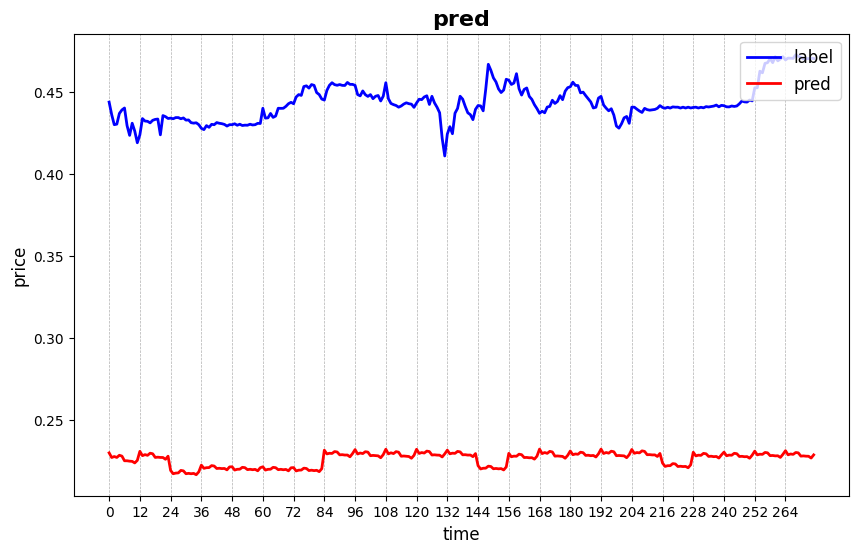

[1.0952069759368896, 1.098431944847107, 1.0999888181686401, 1.1010452508926392, 1.1006560325622559, 1.10232412815094, 1.1017124652862549, 1.10232412815094, 1.1034361124038696, 1.1046504974365234, 1.106216311454773, 1.1084959506988525, 1.1056602001190186, 1.107884407043457, 1.1117209196090698, 1.1135002374649048, 1.113389015197754, 1.1157243251800537, 1.116725206375122, 1.1159467697143555, 1.1156686544418335, 1.112833023071289, 1.113722562789917, 1.1109424829483032, 1.1097192764282227, 1.111573576927185, 1.109997272491455, 1.1092743873596191, 1.110108494758606, 1.110196828842163, 1.1103869676589966, 1.1088296175003052, 1.1061606407165527, 1.1045482158660889, 1.103992223739624, 1.107884407043457, 1.1056602001190186, 1.1053822040557861, 1.1046037673950195, 1.1045482158660889, 1.1037697792053223, 1.1041033267974854, 1.1044925451278687, 1.1058826446533203, 1.1053189039230347, 1.1024909019470215, 1.102768898010254, 1.1049374341964722, 1.074522852897644, 1.0795270204544067, 1.0781370401382446

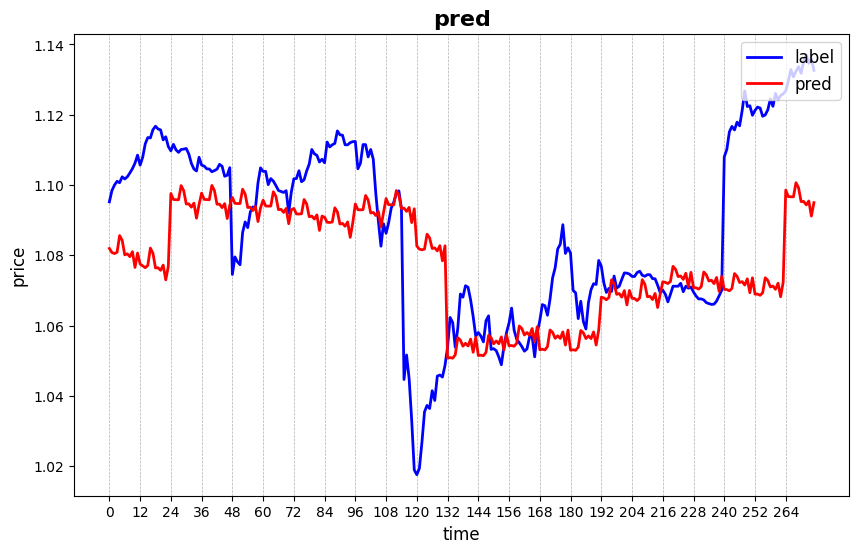

[0.44337883591651917, 0.44504690170288086, 0.44526931643486023, 0.4446020722389221, 0.44465768337249756, 0.443712443113327, 0.44399046897888184, 0.44399046897888184, 0.4447844624519348, 0.44426846504211426, 0.44426846504211426, 0.44426846504211426, 0.44493570923805237, 0.44454649090766907, 0.4440193772315979, 0.4440460503101349, 0.44399046897888184, 0.44399046897888184, 0.44426846504211426, 0.4440460503101349, 0.44454649090766907, 0.44462209939956665, 0.44449087977409363, 0.4449912905693054, 0.44454649090766907, 0.44399046897888184, 0.44476887583732605, 0.4461589455604553, 0.4438236355781555, 0.44449087977409363, 0.44454649090766907, 0.4438798129558563, 0.4426559805870056, 0.4442128539085388, 0.44399046897888184, 0.4430451989173889, 0.44565853476524353, 0.44838306307792664, 0.4509407579898834, 0.4515523910522461, 0.4523308277130127, 0.4505515396595001, 0.4522196352481842, 0.4496062994003296, 0.4484386444091797, 0.4502735435962677, 0.4502735435962677, 0.4497731029987335, 0.4492726922035

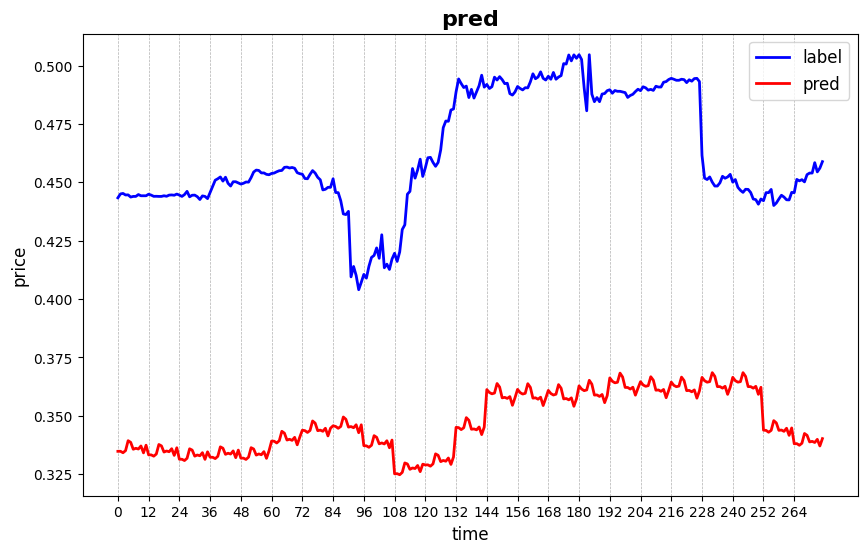

[0.33450913429260254, 0.3377896845340729, 0.33528757095336914, 0.33523139357566833, 0.3369000256061554, 0.336677610874176, 0.33206260204315186, 0.3197188675403595, 0.330506294965744, 0.3143810033798218, 0.3045949637889862, 0.29197320342063904, 0.2947533428668976, 0.2975890636444092, 0.3078199326992035, 0.3117126524448395, 0.3159934878349304, 0.3225773870944977, 0.3153262734413147, 0.31087806820869446, 0.3084315359592438, 0.30220407247543335, 0.30223187804222107, 0.3004247844219208, 0.3016480505466461, 0.2963874936103821, 0.30002668499946594, 0.3048284947872162, 0.3015924394130707, 0.2991459369659424, 0.2997019588947296, 0.30025798082351685, 0.2963102161884308, 0.29158398509025574, 0.2884146571159363, 0.2933632731437683, 0.2899715304374695, 0.28357723355293274, 0.28085270524024963, 0.28024107217788696, 0.2835966944694519, 0.2860320806503296, 0.2834799289703369, 0.2809077501296997, 0.28485608100891113, 0.2858847379684448, 0.28885945677757263, 0.2953093647956848, 0.3004247844219208, 0.301

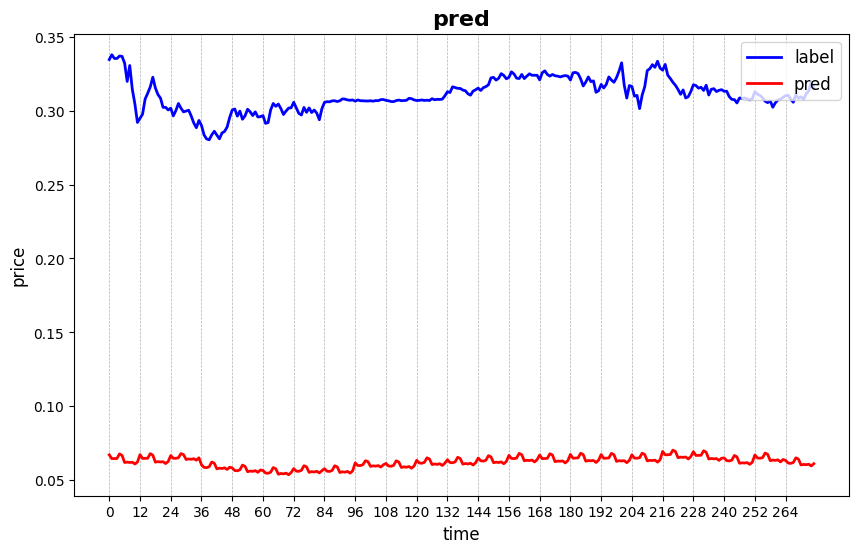

[1.7847336530685425, 1.77293860912323, 1.7965880632400513, 1.8153705596923828, 1.7912946939468384, 1.810116171836853, 1.812053918838501, 1.814369797706604, 1.8129241466522217, 1.815204381942749, 1.8150113821029663, 1.809059739112854, 1.7887609004974365, 1.7900781631469727, 1.8017040491104126, 1.8018035888671875, 1.7966325283050537, 1.7876805067062378, 1.7891262769699097, 1.790571928024292, 1.7945196628570557, 1.8013031482696533, 1.807888150215149, 1.8126516342163086, 1.809865951538086, 1.8162879943847656, 1.8105888366699219, 1.8061127662658691, 1.813063144683838, 1.8096991777420044, 1.805417776107788, 1.7969605922698975, 1.800113320350647, 1.806474208831787, 1.8100606203079224, 1.8104959726333618, 1.8145371675491333, 1.8029378652572632, 1.8106999397277832, 1.8120900392532349, 1.8202636241912842, 1.8178727626800537, 1.8223764896392822, 1.8215980529785156, 1.8225433826446533, 1.8211255073547363, 1.819429636001587, 1.8256492614746094, 1.8254902362823486, 1.820119023323059, 1.8213757276535

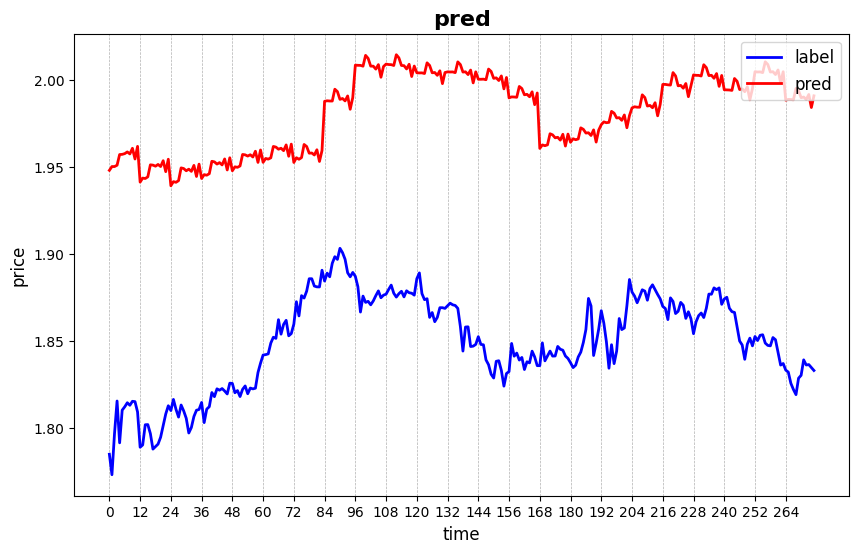

[0.2802966833114624, 0.287859171628952, 0.2911391854286194, 0.2837996482849121, 0.2866353690624237, 0.28406041860580444, 0.28218716382980347, 0.28663480281829834, 0.2845780849456787, 0.2813531160354614, 0.28245073556900024, 0.2866353690624237, 0.2861349582672119, 0.28385522961616516, 0.28318801522254944, 0.28432896733283997, 0.28863707184791565, 0.29330766201019287, 0.306930273771286, 0.31109991669654846, 0.317772775888443, 0.32055288553237915, 0.3140473961830139, 0.3201086223125458, 0.32172054052352905, 0.3296995162963867, 0.3344535231590271, 0.33311906456947327, 0.3289349675178528, 0.33195140957832336, 0.330728143453598, 0.33400869369506836, 0.32761386036872864, 0.3184399902820587, 0.3209977149963379, 0.3224433660507202, 0.3215537369251251, 0.317772775888443, 0.32055234909057617, 0.3219429552555084, 0.3215537369251251, 0.3194408416748047, 0.31955206394195557, 0.32016366720199585, 0.31872522830963135, 0.3194408416748047, 0.31977444887161255, 0.32222098112106323, 0.3194408416748047, 0.

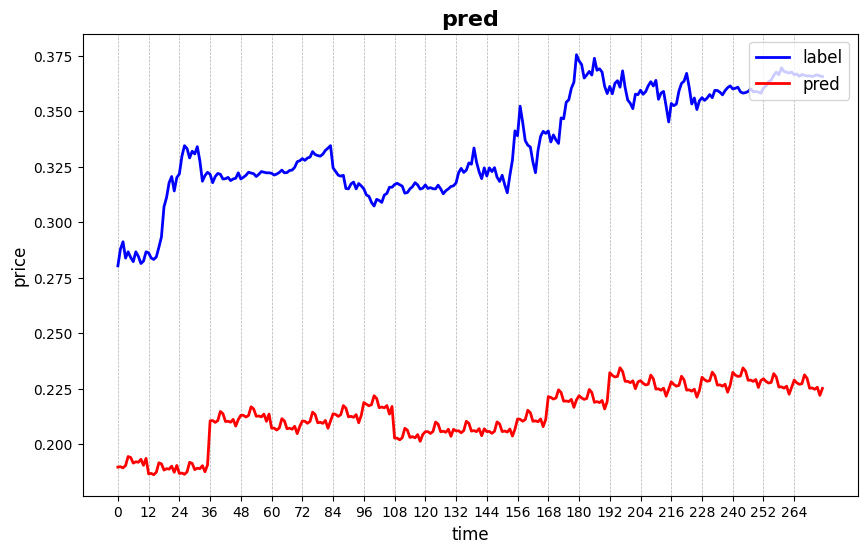

In [9]:
import matplotlib.pyplot as plt
import random
random.shuffle(result)
cnt = 0

for item in result:
    if item.pred_idx == 0: continue
    if item.loss > 2.0: continue
    # 创建一个图形
    plt.figure(figsize=(10, 6))  # 设置图形的大小
    x = range(len(item.seq))
    print(item.seq)
    print(item.pred)
    print(item.loss)
    # 绘制折线图
    plt.plot(x, item.seq, label='label', color='blue', linewidth=2)  # 线条颜色、宽度
    plt.plot(x, item.pred, label='pred', color='red', linewidth=2)  # 线条颜色、宽度
    # 添加标题和标签
    plt.title('pred', fontsize=16, fontweight='bold')  # 图形标题
    plt.xlabel('time', fontsize=12)  # X轴标签
    plt.ylabel('price', fontsize=12)  # Y轴标签

    # 添加网格
    plt.xticks(list(range(0, len(item.seq), 12)), fontsize=10)
    # 添加网格线，按照12的步长
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='x')  # 只在X轴添加网格线
    
    # 添加图例
    plt.legend(loc='upper right', fontsize=12)
    # 美化X轴和Y轴的刻度
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # 显示图形
    plt.show()
    cnt += 1
    if cnt > 10:
        break
    